# Irgendwas stimmt derzeit mit min_connectivity nicht, für alle werte kommt dasselbe raus

In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from model import CulturalModel
import pandas as pd

In [28]:
min_connectivity = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
all_runs_data = []
for mc_value in min_connectivity:
    model = CulturalModel(
        width=10,
        height=10,
        min_connectivity=mc_value,
        use_distance=True,
        difference_threshhold=0.3,
        seed=42)
    for _ in range(50):
        model.step()
    run_data = model.datacollector.get_model_vars_dataframe()
    run_data['min_connectivity'] = mc_value
    run_data['Step'] = run_data.index
    all_runs_data.append(run_data)

final_combined_data = pd.concat(all_runs_data, ignore_index=True)

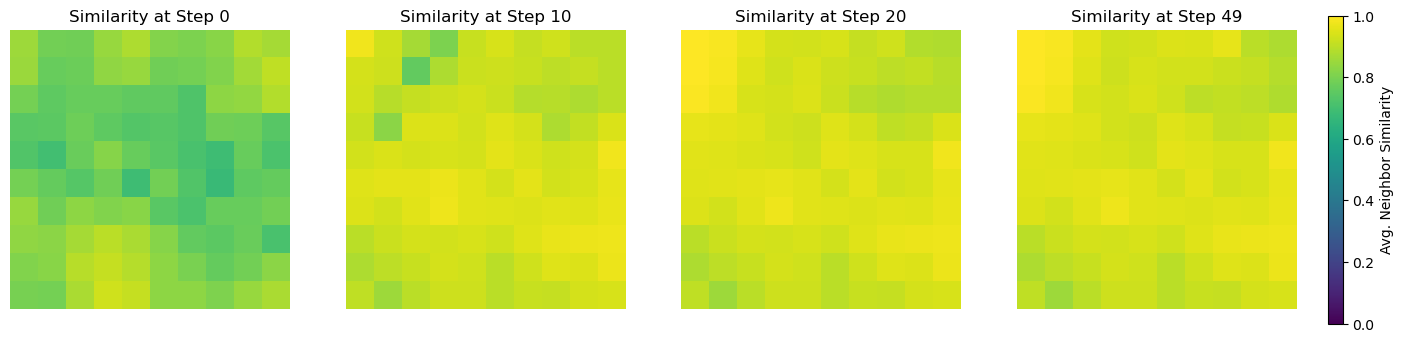

In [13]:
# Store similarity grids here
similarity_grids = []

# Run model and collect similarity maps
model = CulturalModel(width=10, height=10, difference_threshhold=0.3, use_distance=True, seed=42, min_connectivity=.2)

for step in range(50):
    model.step()

    similarity_grid = np.zeros((model.grid.width, model.grid.height))

    for agent in model.agents:
        x, y = agent.pos
        neighbors = model.grid.get_neighbors(agent.pos, moore=True, include_center=False)
        if not neighbors:
            similarity_grid[x][y] = 1.0  # No neighbors = max similarity trivially
            continue

        similarities = []
        for neighbor in neighbors:
            sim = sum(1 - abs(agent.culture[i] - neighbor.culture[i]) for i in range(5)) / 5
            similarities.append(sim)

        similarity_grid[x][y] = sum(similarities) / len(similarities)

    similarity_grids.append(similarity_grid.T)  # transpose for imshow()

# Plot snapshots at selected steps
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
steps_to_plot = [0, 10, 20, 49]

for i, step in enumerate(steps_to_plot):
    im = axes[i].imshow(similarity_grids[step], cmap='viridis', vmin=0, vmax=1)
    axes[i].set_title(f"Similarity at Step {step}")
    axes[i].axis('off')

cbar = fig.colorbar(im, ax=axes, location='right', shrink=0.8, pad=0.02)
cbar.set_label("Avg. Neighbor Similarity")

plt.show()

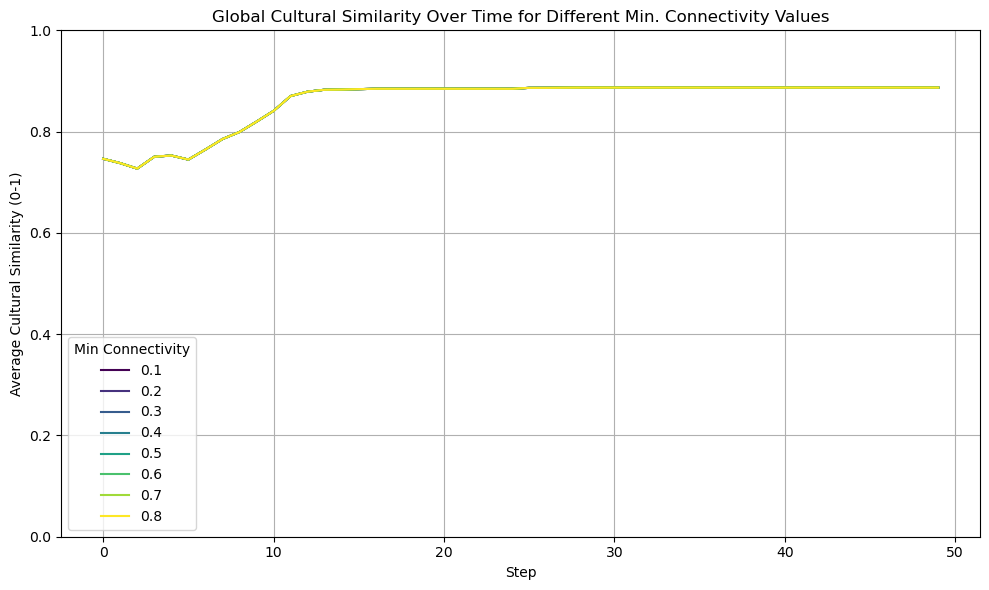

In [29]:
import seaborn as sns
# --- Plotting the combined data ---
plt.figure(figsize=(10, 6)) # Adjusted figure size slightly

# Using seaborn for easier plotting of multiple lines based on a category
# If you prefer pure matplotlib, you'd loop through unique 'min_connectivity' values
# and plot each one separately.
sns.lineplot(data=final_combined_data, x="Step", y="AverageCultureSimilarity", hue="min_connectivity", palette="viridis", legend="full")

plt.xlabel("Step")
plt.ylabel("Average Cultural Similarity (0-1)")
plt.title("Global Cultural Similarity Over Time for Different Min. Connectivity Values")
plt.grid(True)
plt.ylim(0, 1) # Ensure y-axis is between 0 and 1 for similarity
plt.legend(title="Min Connectivity") # Add legend title
plt.tight_layout()
plt.show()


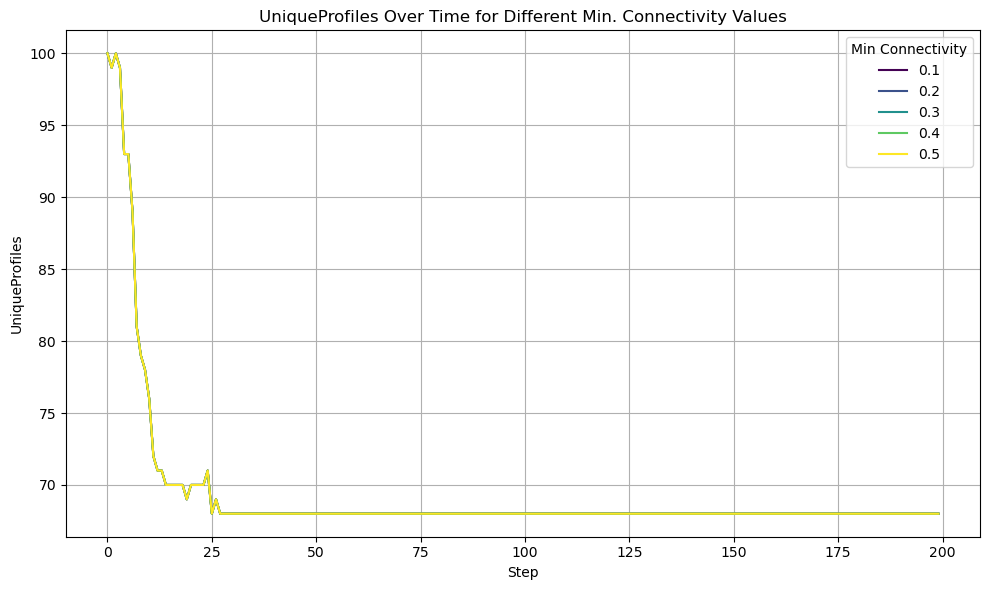

In [27]:
import seaborn as sns
# --- Plotting the combined data ---
plt.figure(figsize=(10, 6)) # Adjusted figure size slightly

# Using seaborn for easier plotting of multiple lines based on a category
# If you prefer pure matplotlib, you'd loop through unique 'min_connectivity' values
# and plot each one separately.
sns.lineplot(data=final_combined_data, x="Step", y="UniqueProfiles", hue="min_connectivity", palette="viridis", legend="full")

plt.xlabel("Step")
plt.ylabel("UniqueProfiles")
plt.title("UniqueProfiles Over Time for Different Min. Connectivity Values")
plt.grid(True)
plt.legend(title="Min Connectivity") # Add legend title
plt.tight_layout()
plt.show()


In [ ]:

# Plotting Unique Profiles (Optional, similar approach)
plt.figure(figsize=(10, 6))
sns.lineplot(data=final_combined_data, x="Step", y="UniqueProfiles", hue="min_connectivity", palette="viridis", legend="full")
plt.xlabel("Step")
plt.ylabel("Number of Unique Cultural Profiles")
plt.title("Unique Cultural Profiles Over Time for Different Min. Connectivity Values")
plt.grid(True)
plt.legend(title="Min Connectivity")
plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

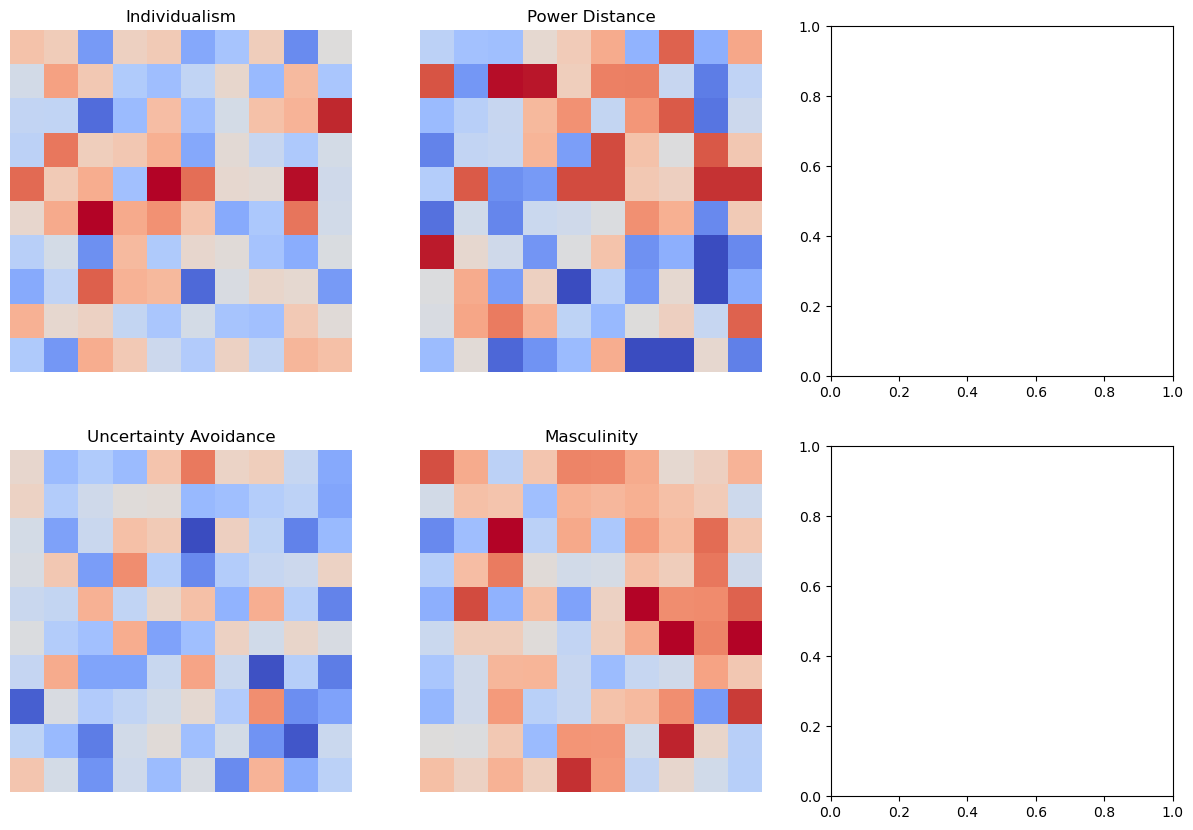

In [8]:
#how each Hofstede dimension converged spatially across the grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
dimension_names = ["Individualism", "Power Distance", "Uncertainty Avoidance", 
                   "Masculinity", "Long-Term Orientation"]

for i in range(6):
    grid = np.zeros((model.grid.width, model.grid.height))
    for agent in model.agents:
        x, y = agent.pos
        grid[x][y] = agent.culture[i]
    ax = axes[i // 2][i % 2]
    im = ax.imshow(grid.T, cmap='coolwarm', vmin=0, vmax=1)
    ax.set_title(f"{dimension_names[i]}")
    ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label="Cultural Value")
plt.suptitle("Final Culture Values per Hofstede Dimension", fontsize=16)
#plt.tight_layout()
plt.show()

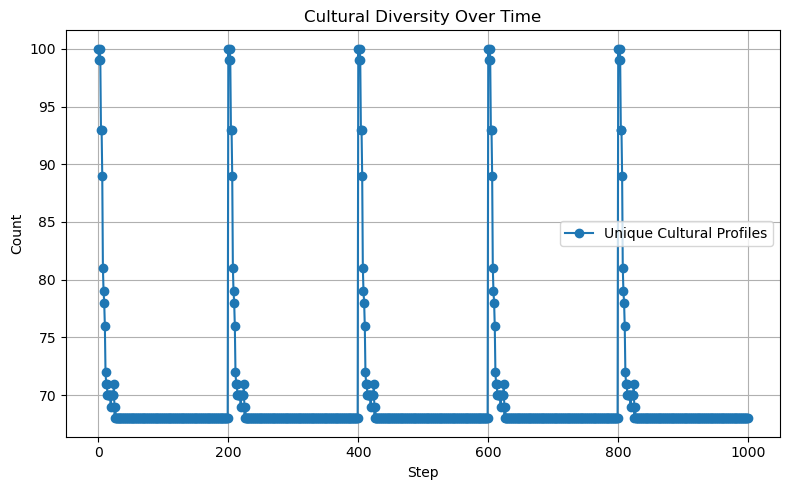

In [20]:
#tracking the number of unique cultural profiles over time
plt.figure(figsize=(8, 5))
plt.plot(final_combined_data["UniqueProfiles"], marker='o', label="Unique Cultural Profiles")
plt.xlabel("Step")
plt.ylabel("Count")
plt.title("Cultural Diversity Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

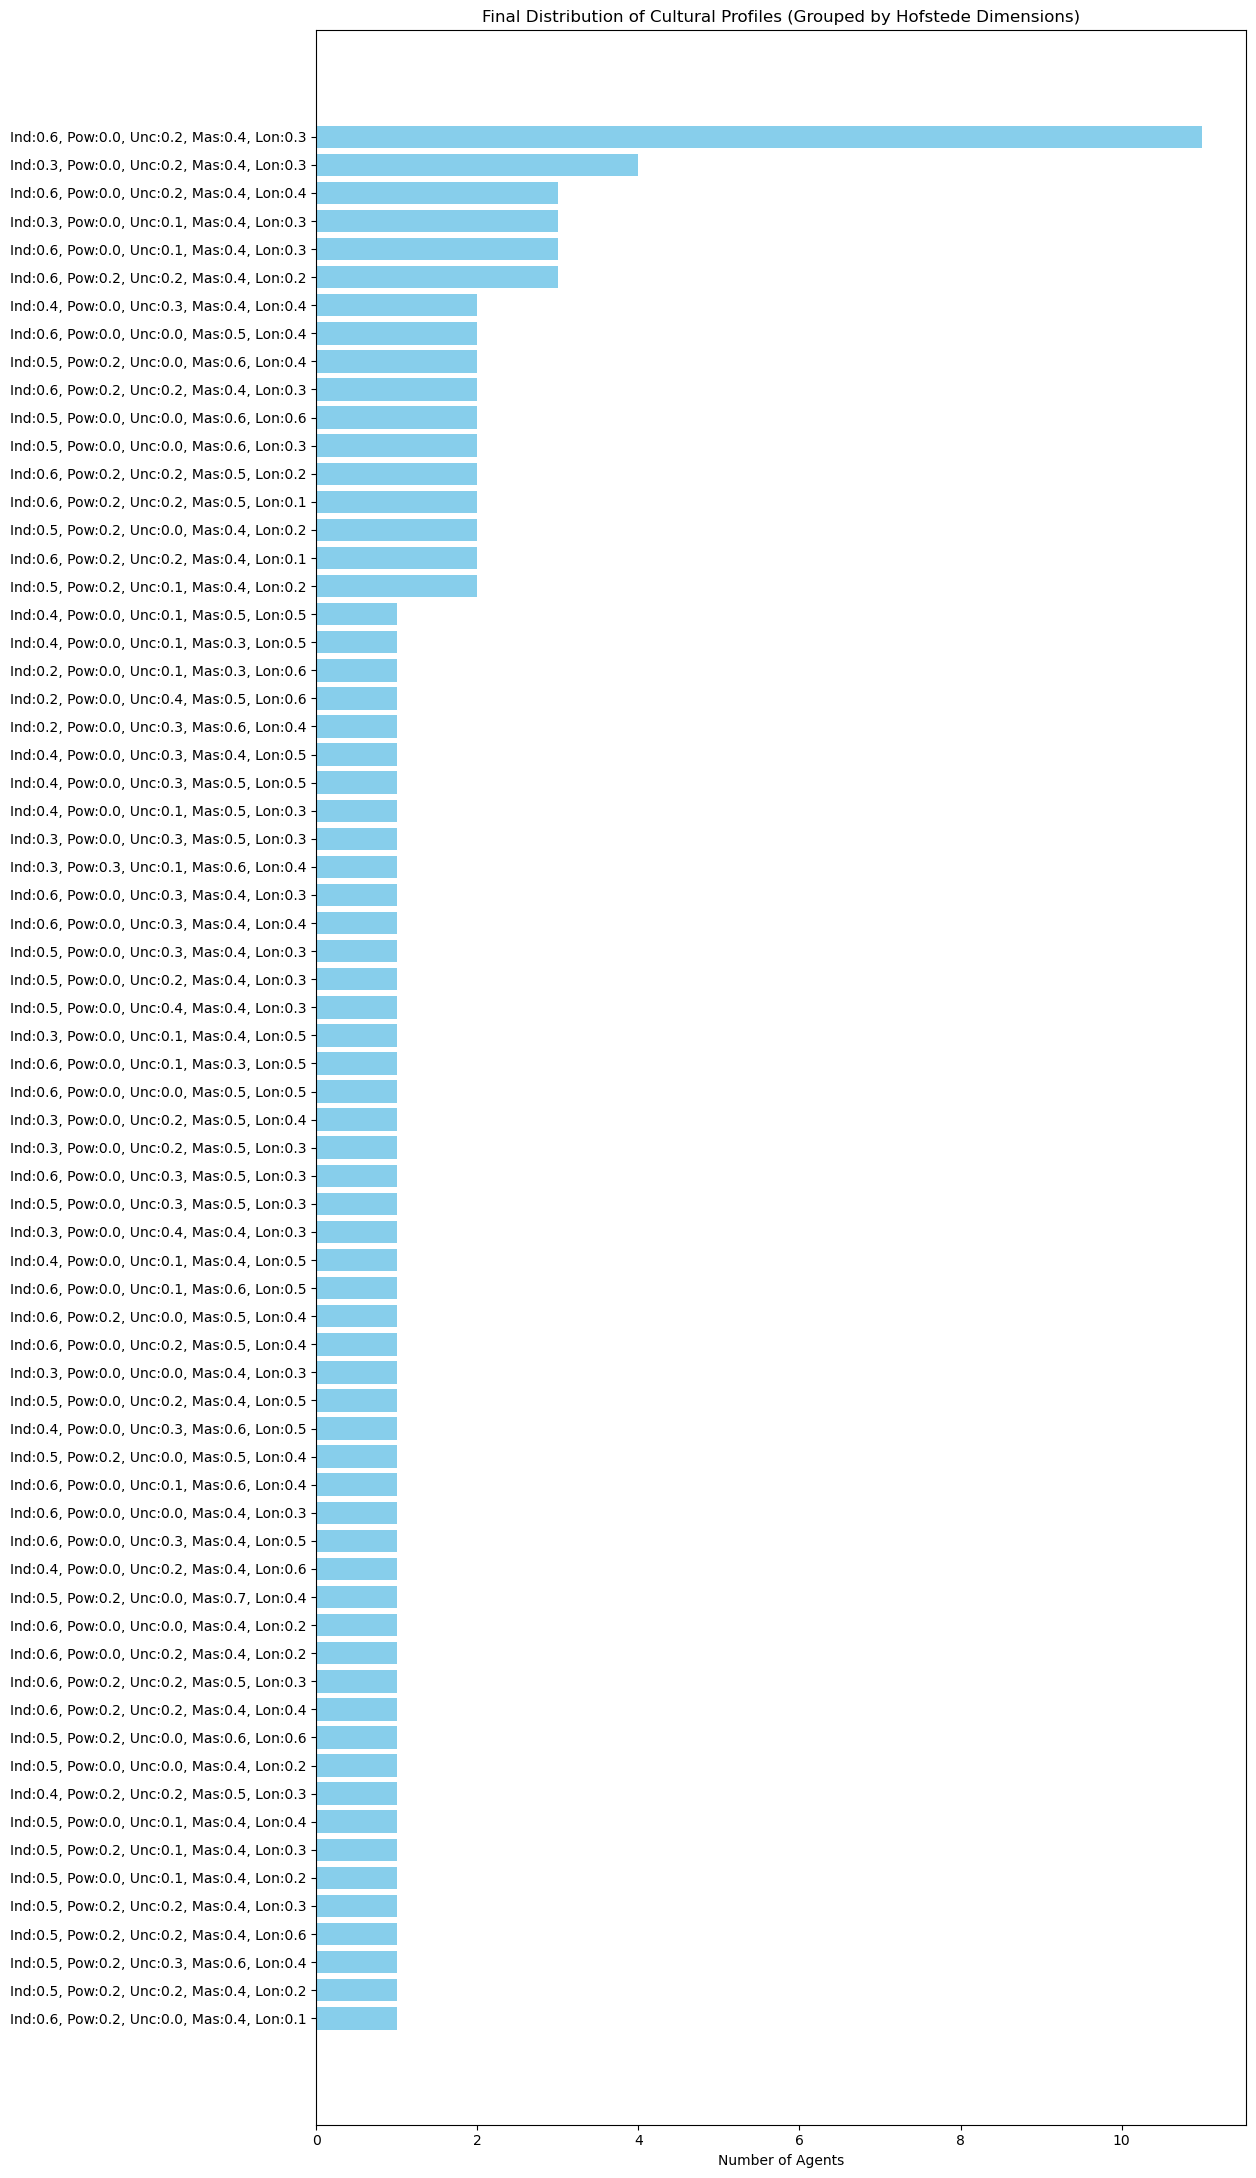

In [21]:
from collections import Counter

# Hofstede dimension names in order
hofstede_dims = [
    "Individualism", "Power Distance", "Uncertainty Avoidance",
    "Masculinity", "Long-Term Orientation", "Indulgence"
]

# Step 1: Count unique cultural profiles
profiles = [
    tuple(round(v, 1) for v in agent.culture)
    for agent in model.agents
]
profile_counts = Counter(profiles)

# Step 2: Sort by number of agents per profile
sorted_profiles = sorted(profile_counts.items(), key=lambda x: -x[1])

# Step 3: Convert tuples into readable labels
# Step 3: Shorter, single-line profile labels
labels = [
    ", ".join([f"{hofstede_dims[i][:3]}:{profile[i]}" for i in range(5)])
    for profile, _ in sorted_profiles]

values = [count for _, count in sorted_profiles]

# Step 4: Plot histogram
plt.figure(figsize=(12, max(4, len(labels) * 0.4)))  # dynamic height if many labels
plt.barh(labels, values, color='skyblue')
plt.xlabel("Number of Agents")
plt.title("Final Distribution of Cultural Profiles (Grouped by Hofstede Dimensions)")
plt.gca().invert_yaxis()
plt.show()

c:\Users\danie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cultural Type 0:
  Individualism: 0.38
  Power Distance: 0.0
  Uncertainty Avoidance: 0.22
  Masculinity: 0.41
  Long-Term Orientation: 0.3

Cultural Type 1:
  Individualism: 0.57
  Power Distance: 0.24
  Uncertainty Avoidance: 0.14
  Masculinity: 0.4
  Long-Term Orientation: 0.2

Cultural Type 2:
  Individualism: 0.41
  Power Distance: 0.02
  Uncertainty Avoidance: 0.21
  Masculinity: 0.4
  Long-Term Orientation: 0.52

Cultural Type 3:
  Individualism: 0.48
  Power Distance: 0.15
  Uncertainty Avoidance: 0.06
  Masculinity: 0.56
  Long-Term Orientation: 0.44

Cultural Type 4:
  Individualism: 0.63
  Power Distance: 0.0
  Uncertainty Avoidance: 0.18
  Masculinity: 0.4
  Long-Term Orientation: 0.33


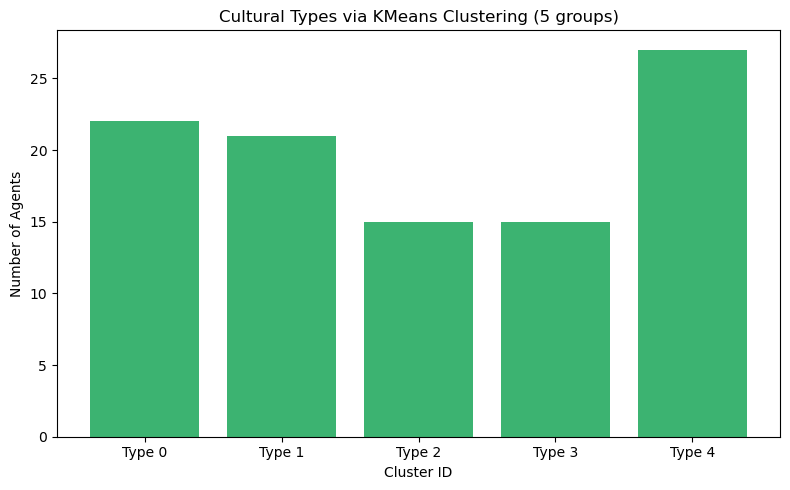

In [23]:
from sklearn.cluster import KMeans

# Step 1: Collect all agent culture vectors
X = np.array([agent.culture for agent in model.agents])

# Step 2: Choose number of clusters (e.g., 4–6 for interpretability)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Step 3: Count agents in each cluster
counts = np.bincount(cluster_labels)

for i, center in enumerate(kmeans.cluster_centers_):
    print(f"\nCultural Type {i}:")
    for dim, value in zip(hofstede_dims, center):
        print(f"  {dim}: {round(value, 2)}")

# Step 4: Plot results
plt.figure(figsize=(8, 5))
plt.bar(range(n_clusters), counts, color='mediumseagreen')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Agents")
plt.title(f"Cultural Types via KMeans Clustering ({n_clusters} groups)")
plt.xticks(range(n_clusters), [f"Type {i}" for i in range(n_clusters)])
plt.tight_layout()
plt.show()